In [54]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
df = pd.read_csv('data/covid_19_data.csv')

In [55]:
# I referred code regarding data preprocessing from https://www.kaggle.com/chirag9073/coronavirus-covid-19-outbreak-data-analysis

df.drop(['SNo'], axis=1, inplace=True)
df['ObservationDate'] = df['ObservationDate'].apply(pd.to_datetime)

In [56]:
df.head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [57]:
df.isnull().sum()

ObservationDate      0
Province/State     982
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [58]:
df[df['Province/State'].isnull()].head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,2020-01-22,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0
36,2020-01-22,NaN,Thailand,1/22/2020 17:00,2.0,0.0,0.0
37,2020-01-22,NaN,South Korea,1/22/2020 17:00,1.0,0.0,0.0
73,2020-01-23,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0
74,2020-01-23,NaN,Thailand,1/23/20 17:00,3.0,0.0,0.0
75,2020-01-23,NaN,South Korea,1/23/20 17:00,1.0,0.0,0.0
76,2020-01-23,NaN,Singapore,1/23/20 17:00,1.0,0.0,0.0
77,2020-01-23,NaN,Philippines,1/23/20 17:00,0.0,0.0,0.0
78,2020-01-23,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
79,2020-01-23,NaN,Vietnam,1/23/20 17:00,2.0,0.0,0.0


In [59]:
# Current situation
grouped_df = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
grouped_df.style.background_gradient(cmap='Pastel1_r')

In [60]:
# Top 10 Countries with most no. of reported cases
latest_df = df[df['ObservationDate'] == max(df['ObservationDate'])].reset_index()
grouped_df = latest_df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

temp = grouped_df[['Country/Region', 'Confirmed']]
temp = temp.sort_values(by='Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.head(10).style.background_gradient(cmap='Pastel1_r')

,Country/Region,Confirmed
0,Mainland China,80026
1,South Korea,4335
2,Italy,2036
3,Iran,1501
4,Others,705
5,Japan,274
6,France,191
7,Germany,159
8,Spain,120
9,Singapore,108


In [61]:
# Countries with all the cases recovered
temp = grouped_df[grouped_df['Confirmed']==grouped_df['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Vietnam,16,16
1,Cambodia,1,1
2,Nepal,1,1
3,Sri Lanka,1,1


In [62]:
# Most recent stats
world_daily_df = df.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
world_daily_df = world_daily_df.reset_index()
world_daily_df = world_daily_df.sort_values('ObservationDate', ascending=False)
world_daily_df.head(1).style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602


In [63]:
world_daily_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602
39,2020-03-01 00:00:00,88371,2996,42716
38,2020-02-29 00:00:00,86013,2941,39782
37,2020-02-28 00:00:00,84124,2872,36711
36,2020-02-27 00:00:00,82756,2814,33277
35,2020-02-26 00:00:00,81397,2770,30384
34,2020-02-25 00:00:00,80415,2708,27905
33,2020-02-24 00:00:00,79570,2629,25227
32,2020-02-23 00:00:00,78985,2469,23394
31,2020-02-22 00:00:00,78599,2458,22886


In [64]:
world_daily_df.isnull().sum()

ObservationDate    0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [65]:
# from https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
import keras

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [66]:

import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

WINDOW_SIZE = 8

class PandemicRegressor():
    def __init__(self, window_size, batch_size, n_feature, model_name, hidden_state=False, stateful=False, loss_hist=None):
        self.window_size = window_size
        self.batch_size = batch_size
        self.n_feature = n_feature
        save_dir = os.path.join(os.path.join(os.getcwd(), 'model'), 
                                datetime.datetime.now().strftime('%Y-%m-%d;%H.%M.%S'))
        os.mkdir(save_dir)
        self.model_path = os.path.join(save_dir, model_name + '.best.hdf5')
        print(self.model_path)
        self.hidden_state = hidden_state
        self.stateful = stateful
        if stateful:
            self.callbacks = [loss_hist]
        else:
            self.callbacks = [EarlyStopping(monitor='val_mape', patience=100), 
                 ModelCheckpoint(self.model_path, monitor='val_mape', verbose=0, save_best_only=True, mode='min')]
        self.reg = self.build_model(hidden_state, stateful)
        
    def build_model(self, hidden_state, stateful):
        model = Sequential()
        if hidden_state:
            if stateful:
                model.add(LSTM(1024, batch_input_shape=(self.batch_size, self.window_size, self.n_feature), dropout=0.5, stateful=True))
            else:
                model.add(LSTM(1024, input_shape=(self.window_size, self.n_feature), dropout=0.5))
        else:
             model.add(Dense(1024, input_dim=(self.window_size * self.n_feature),activation='relu'))
        
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.n_feature, activation='linear'))

        model.compile(loss='mean_squared_error', 
                      optimizer='adam',
                      metrics=['mae', 'mape'])
        return model
    
    def reset_states(self):
        # reset hiden states
        self.reg.reset_states()
    
    def fit(self, X_train, y_train, validation_data, epochs=500, verbose=1, shuffle=False):
        hist = self.reg.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=self.batch_size,
                            validation_data=validation_data,
                            callbacks=self.callbacks,
                            verbose=verbose,
                            shuffle=shuffle)
        return hist
    
    def predict_n_days(self, n, seq_in, scaler):
        _mean = scaler['mean']
        _std = scaler['std']
        
        if self.hidden_state:
            seq_in = list(seq_in)
            seq_out = []
            for i in range(n):
                temp = np.array(seq_in)
                temp = np.reshape(temp, (1, self.window_size, self.n_feature)) # n_sample, seq_len, n_feature
                y_hat = self.reg.predict(temp)
                seq_out.append(y_hat[0])
                y_hat = (y_hat - _mean) / _std
                seq_in.append(y_hat[0])
                seq_in.pop(0)
        else:
            seq_in = list(seq_in)
            seq_out = []
            for i in range(n):
                temp = np.array(seq_in)
                temp = np.reshape(temp, (1, self.window_size * self.n_feature)) # n_sample, seq_len, n_feature
                y_hat = self.reg.predict(temp)
                seq_out.append(y_hat[0])
                y_hat = (y_hat - _mean) / _std
                seq_in.append(y_hat[0])
                seq_in.pop(0)
        _df = pd.DataFrame(seq_out)
        _df.columns = ['Confirmed', 'Deaths', 'Recovered']
        return _df
    
    def predict(self, X):
        return self.reg.predict(X, batch_size=self.batch_size)
    
    def evaluate(self, X_test, y_test):
        loss_and_metrics = self.reg.evaluate(X_test, 
                                             y_test, 
                                             batch_size=self.batch_size)
        return loss_and_metrics
    
    def load_best_weights(self):
        self.reg.load_weights(self.model_path)
    
    def save(self):
        self.reg.save(self.model_path)


In [67]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def show_train_hist(hist):
    plt.plot(hist.history['loss'], 'b-', label='train_loss')
    plt.plot(hist.history['val_loss'], 'r', label='val_loss')
    plt.title("loss history")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Normalize
_mean = np.mean(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)

print(_mean)
print(_std)

[46077.41463415  1313.85365854 11462.34146341]
[31966.13245523  1056.92768198 13683.82920771]


In [68]:
def seq2dataset(sr, window_size):
        seq_data = []
        for i in range(len(sr) - window_size):
            subset = list(sr[i:(i+window_size+1)])
            subset.reverse()
            seq_data.append(subset)
        seq_data.reverse()
        seq_data = np.array(seq_data)
        return seq_data[:,0:window_size,:], seq_data[:,window_size,:]

In [69]:
X, y = seq2dataset(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X

array([[[  555.,    17.,    28.],
        [  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.]],

       [[  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.]],

       [[  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.],
        [ 9925.,   213.,   222.]],

       [[ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        

In [70]:
y

array([[ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80415.,  2708., 27905.],
       [81397.,  2770., 30384.],
       [82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86

In [71]:
X = (X - _mean) / _std

In [72]:
X

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804],
        [-1.18382837, -1.08129788, -0.8272057 ]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.2669

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [74]:
X_train

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804],
        [-1.18382837, -1.08129788, -0.8272057 ]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.2669

In [75]:
X_test

array([[[0.92484086, 0.76461839, 0.34044992],
        [0.94229683, 0.8828857 , 0.49070026],
        [0.96244315, 0.88667026, 0.54280556],
        [1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512]],

       [[0.94229683, 0.8828857 , 0.49070026],
        [0.96244315, 0.88667026, 0.54280556],
        [1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255]],

       [[0.96244315, 0.88667026, 0.54280556],
        [1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.3777161

In [76]:
y_train

array([[ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80415.,  2708., 27905.],
       [81397.,  2770., 30384.]])

In [77]:
y_test

array([[82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86013.,  2941., 39782.],
       [88371.,  2996., 42716.],
       [90309.,  3085., 45602.]])

In [78]:
"""
Predict the global spread of coronavirus with LSTM statue modle
"""
import sys

loss_hist = LossHistory()
loss_hist.init()
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=True, batch_size=1, n_feature=3, model_name='world_stateful_pdm_reg', stateful=True, loss_hist=loss_hist)

min_mape = float(sys.maxsize)
patience = 200
n_mape_greater = 0
epochs = 3
for i in range(epochs):
    hist = pdm_reg.fit(X_train=X_train, 
                       y_train=y_train, 
                       validation_data=(X_test, y_test),
                       epochs=1,
                       verbose=0)
    print(f'Epoch {i}/{epochs}')
    print(f"loss: {hist.history['loss']}, mae: {hist.history['mae']}, mape: {hist.history['mape']},"
          f"val_loss: {hist.history['val_loss']}, val_mae: {hist.history['val_mae']}, val_mape: {hist.history['val_mape']}")
    val_mape = hist.history['val_mae'][0]
    print(val_mape)
    if val_mape <= min_mape:
        min_mape = val_mape
        n_mape_greater = 0
        pdm_reg.save()
    else:
        n_mape_greater += 1
    if n_mape_greater > patience:
        break
pdm_reg.reset_states()

pdm_reg.load_best_weights()
loss_and_metrics = pdm_reg.evaluate(X_test=X_test, y_test=y_test)
pdm_reg.reset_states()

C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;03.55.13\world_stateful_pdm_reg.best.hdf5
Epoch 0/3
loss: [1104480319.7142856], mae: [20382.059], mape: [97.15265],val_loss: [2683784089.6], val_mae: [40283.6015625], val_mape: [83.08452606201172]
40283.6015625
Epoch 1/3
loss: [146018685.82142857], mae: [7510.8745], mape: [140.5723],val_loss: [128495977.6], val_mae: [10052.775390625], val_mape: [60.917755126953125]
10052.775390625
Epoch 2/3
loss: [792026291.625], mae: [18870.389], mape: [759.58936],val_loss: [1055513152.0], val_mae: [26149.361328125], val_mape: [47.03224182128906]
26149.361328125
5/5 [==============================] - 0s 6ms/step


In [79]:
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = pdm_reg.predict(X_test)
pdm_reg.reset_states()
y_dict = {'Confirmed': [x[0] for x in y_hat],
          'Deaths':[x[1] for x in y_hat],
          'Recovered':[x[2] for x in y_hat]}
y_df = pd.DataFrame(y_dict)
y_df

MAE: 42930.0, MAPE: 99.96434020996094
===================================================== Prediction of X_test =====================================================


,Confirmed,Deaths,Recovered
0,68.558586,-0.525719,18.927271
1,72.450211,-0.546423,20.012859
2,71.113235,-0.534550,19.649555
3,65.615379,-0.486636,18.136915
4,52.541241,-0.374706,14.510978


In [80]:
n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = pdm_reg.predict_n_days(n, X_test[-1], {'mean': _mean, 'std': _std})
pdm_reg.reset_states()
prediction


===================================================== Prediction of 7 days =====================================================


,Confirmed,Deaths,Recovered
0,70.994789,-0.549631,19.610567
1,77.321297,-0.587712,21.361862
2,84.073418,-0.644118,23.218529
3,95.887428,-0.751337,26.460028
4,97.170464,-0.761376,26.804129
5,94.354874,-0.733378,26.024084
6,93.539223,-0.723724,25.796469


In [81]:
print(df['Country/Region'].unique())
nation_name = 'South Korea'

['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal']


In [82]:
korea_df = df[df['Country/Region'] == nation_name].groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
korea_df = korea_df.reset_index()
korea_df = korea_df.sort_values('ObservationDate', ascending=False)
korea_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,4335,28,30
39,2020-03-01 00:00:00,3736,17,30
38,2020-02-29 00:00:00,3150,16,27
37,2020-02-28 00:00:00,2337,13,22
36,2020-02-27 00:00:00,1766,13,22
35,2020-02-26 00:00:00,1261,12,22
34,2020-02-25 00:00:00,977,10,22
33,2020-02-24 00:00:00,833,8,18
32,2020-02-23 00:00:00,602,6,18
31,2020-02-22 00:00:00,433,2,16


In [83]:
# for nation_name in df['Country/Region'].unique():
print(f'[{nation_name} spread of coronavirus19]')
_mean = np.mean(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
    
X, y = seq2dataset(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X = (X - _mean) / _std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

[South Korea spread of coronavirus19]


C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;03.55.23\korea_pdm_reg.best.hdf5
Train on 28 samples, validate on 5 samples
Epoch 1/3000
28/28 [==============================] - 1s 40ms/step - loss: 45853.5552 - mae: 61.1281 - mape: 20089220.0000 - val_loss: 3414053.5000 - val_mae: 1035.5292 - val_mape: 99.5161
Epoch 2/3000
28/28 [==============================] - 0s 3ms/step - loss: 43457.0701 - mae: 57.1344 - mape: 241738192.0000 - val_loss: 3397519.5000 - val_mae: 1032.1394 - val_mape: 97.1559
Epoch 3/3000
28/28 [==============================] - 0s 4ms/step - loss: 40887.9972 - mae: 75.8354 - mape: 4174982656.0000 - val_loss: 3326758.7500 - val_mae: 1015.1763 - val_mape: 86.4905
Epoch 4/3000
28/28 [==============================] - 0s 4ms/step - loss: 34716.3775 - mae: 75.4109 - mape: 2658921216.0000 - val_loss: 2924454.7500 - val_mae: 939.4368 - val_mape: 63.0444
Epoch 5/3000
28/28 [==============================] - 0s 4ms/step - loss: 34168.3578 - mae: 88.7

28/28 [==============================] - 0s 3ms/step - loss: 35125.3610 - mae: 91.6843 - mape: 3763359744.0000 - val_loss: 1403061.6250 - val_mae: 626.1725 - val_mape: 79.3454
Epoch 44/3000
28/28 [==============================] - 0s 3ms/step - loss: 30740.3059 - mae: 65.8325 - mape: 3259310592.0000 - val_loss: 1426246.0000 - val_mae: 630.0029 - val_mape: 52.9960
Epoch 45/3000
28/28 [==============================] - 0s 3ms/step - loss: 36886.1686 - mae: 65.5915 - mape: 2974172672.0000 - val_loss: 1515045.3750 - val_mae: 660.3416 - val_mape: 75.3867
Epoch 46/3000
28/28 [==============================] - 0s 3ms/step - loss: 13514.1968 - mae: 54.3419 - mape: 2685085184.0000 - val_loss: 1479298.1250 - val_mae: 651.8329 - val_mape: 77.5921
Epoch 47/3000
28/28 [==============================] - 0s 3ms/step - loss: 19662.8400 - mae: 61.4640 - mape: 3253145600.0000 - val_loss: 1288896.0000 - val_mae: 592.9538 - val_mape: 61.0869
Epoch 48/3000
28/28 [==============================] - 0s 3ms/st

28/28 [==============================] - 0s 3ms/step - loss: 15302.5619 - mae: 64.3167 - mape: 1742035712.0000 - val_loss: 1556024.6250 - val_mae: 664.3597 - val_mape: 70.5866
Epoch 87/3000
28/28 [==============================] - 0s 3ms/step - loss: 13166.4266 - mae: 58.4228 - mape: 3317778176.0000 - val_loss: 1442684.3750 - val_mae: 634.0565 - val_mape: 67.2012
Epoch 88/3000
28/28 [==============================] - 0s 3ms/step - loss: 25066.0016 - mae: 60.1652 - mape: 1922875392.0000 - val_loss: 1499032.7500 - val_mae: 645.8751 - val_mape: 41.7288
Epoch 89/3000
28/28 [==============================] - 0s 3ms/step - loss: 15693.4263 - mae: 51.9656 - mape: 1706745856.0000 - val_loss: 1777856.7500 - val_mae: 722.9621 - val_mape: 80.6623
Epoch 90/3000
28/28 [==============================] - 0s 3ms/step - loss: 14172.1726 - mae: 50.5608 - mape: 1804604416.0000 - val_loss: 1716293.7500 - val_mae: 710.4683 - val_mape: 100.1217
Epoch 91/3000
28/28 [==============================] - 0s 3ms/s

28/28 [==============================] - 0s 3ms/step - loss: 5721.7925 - mae: 34.3292 - mape: 1482156032.0000 - val_loss: 1354695.7500 - val_mae: 621.3351 - val_mape: 89.1944
Epoch 130/3000
28/28 [==============================] - 0s 3ms/step - loss: 6477.2143 - mae: 39.1358 - mape: 1903558656.0000 - val_loss: 1336367.3750 - val_mae: 611.5130 - val_mape: 58.3255
Epoch 131/3000
28/28 [==============================] - 0s 3ms/step - loss: 9556.1677 - mae: 36.7188 - mape: 1327764096.0000 - val_loss: 1222249.5000 - val_mae: 581.4131 - val_mape: 79.2401
Epoch 132/3000
28/28 [==============================] - 0s 3ms/step - loss: 12719.5355 - mae: 54.2012 - mape: 1747705216.0000 - val_loss: 1179222.3750 - val_mae: 574.9725 - val_mape: 110.9398
Epoch 133/3000
28/28 [==============================] - 0s 3ms/step - loss: 14695.9009 - mae: 45.8645 - mape: 1295747328.0000 - val_loss: 1323792.3750 - val_mae: 624.0350 - val_mape: 138.9543
Epoch 134/3000
28/28 [==============================] - 0s 3m

28/28 [==============================] - 0s 3ms/step - loss: 16322.5453 - mae: 41.2854 - mape: 1102233216.0000 - val_loss: 1102205.7500 - val_mae: 543.8626 - val_mape: 56.5776
Epoch 173/3000
28/28 [==============================] - 0s 3ms/step - loss: 5857.6415 - mae: 27.9853 - mape: 527197760.0000 - val_loss: 1029167.8125 - val_mae: 518.7809 - val_mape: 35.2221
Epoch 174/3000
28/28 [==============================] - 0s 3ms/step - loss: 6818.5297 - mae: 35.8660 - mape: 1088641408.0000 - val_loss: 1002880.6250 - val_mae: 510.4798 - val_mape: 29.8745
Epoch 175/3000
28/28 [==============================] - 0s 3ms/step - loss: 7753.8227 - mae: 35.6262 - mape: 1086115840.0000 - val_loss: 959128.3750 - val_mae: 496.6715 - val_mape: 39.4951
Epoch 176/3000
28/28 [==============================] - 0s 3ms/step - loss: 11908.1741 - mae: 42.0118 - mape: 858114944.0000 - val_loss: 1074891.3750 - val_mae: 540.1118 - val_mape: 65.1458
Epoch 177/3000
28/28 [==============================] - 0s 3ms/ste

28/28 [==============================] - 0s 3ms/step - loss: 3048.1368 - mae: 24.1019 - mape: 904099840.0000 - val_loss: 1428775.3750 - val_mae: 636.9125 - val_mape: 56.0400
Epoch 216/3000
28/28 [==============================] - 0s 3ms/step - loss: 9672.0947 - mae: 29.7505 - mape: 774337344.0000 - val_loss: 1411147.3750 - val_mae: 636.6776 - val_mape: 81.0861
Epoch 217/3000
28/28 [==============================] - 0s 3ms/step - loss: 8310.3104 - mae: 24.8488 - mape: 698959232.0000 - val_loss: 1339240.6250 - val_mae: 616.5609 - val_mape: 79.4512
Epoch 218/3000
28/28 [==============================] - 0s 3ms/step - loss: 4754.1924 - mae: 22.9982 - mape: 708345408.0000 - val_loss: 1266743.7500 - val_mae: 593.4818 - val_mape: 66.2585
Epoch 219/3000
28/28 [==============================] - 0s 3ms/step - loss: 6900.4039 - mae: 30.0100 - mape: 837844544.0000 - val_loss: 1190101.6250 - val_mae: 569.8054 - val_mape: 61.0387
Epoch 220/3000
28/28 [==============================] - 0s 3ms/step - 

28/28 [==============================] - 0s 3ms/step - loss: 11089.5687 - mae: 35.6450 - mape: 858405824.0000 - val_loss: 1076662.5000 - val_mae: 532.0235 - val_mape: 32.8232
Epoch 259/3000
28/28 [==============================] - 0s 3ms/step - loss: 11696.4290 - mae: 50.8759 - mape: 1845801344.0000 - val_loss: 1039085.3750 - val_mae: 518.8040 - val_mape: 27.1088
Epoch 260/3000
28/28 [==============================] - 0s 3ms/step - loss: 4676.3357 - mae: 24.1873 - mape: 976325568.0000 - val_loss: 1120560.7500 - val_mae: 545.9815 - val_mape: 39.5069
Epoch 261/3000
28/28 [==============================] - 0s 3ms/step - loss: 18869.7153 - mae: 38.6708 - mape: 532453728.0000 - val_loss: 1183223.7500 - val_mae: 562.1869 - val_mape: 39.5993
Epoch 262/3000
28/28 [==============================] - 0s 3ms/step - loss: 20373.6176 - mae: 47.9649 - mape: 1165316096.0000 - val_loss: 1374993.3750 - val_mae: 611.5052 - val_mape: 30.5341
Epoch 263/3000
28/28 [==============================] - 0s 3ms/s

28/28 [==============================] - 0s 3ms/step - loss: 15158.4847 - mae: 31.3031 - mape: 857093632.0000 - val_loss: 1171733.0000 - val_mae: 558.6927 - val_mape: 70.6012
Epoch 302/3000
28/28 [==============================] - 0s 3ms/step - loss: 5906.5355 - mae: 29.9816 - mape: 962859904.0000 - val_loss: 1058896.7500 - val_mae: 527.5260 - val_mape: 68.6882
Epoch 303/3000
28/28 [==============================] - 0s 3ms/step - loss: 20796.7218 - mae: 34.6747 - mape: 673860992.0000 - val_loss: 896975.1875 - val_mae: 473.8665 - val_mape: 55.2209
Epoch 304/3000
28/28 [==============================] - 0s 3ms/step - loss: 21498.2643 - mae: 44.4430 - mape: 735651968.0000 - val_loss: 939315.3125 - val_mae: 486.4984 - val_mape: 23.1785
Epoch 305/3000
28/28 [==============================] - 0s 3ms/step - loss: 5695.2242 - mae: 25.5071 - mape: 1054307392.0000 - val_loss: 1307378.0000 - val_mae: 607.6096 - val_mape: 58.3799
Epoch 306/3000
28/28 [==============================] - 0s 3ms/step 

28/28 [==============================] - 0s 3ms/step - loss: 6901.7711 - mae: 36.0178 - mape: 1265075584.0000 - val_loss: 1022188.6250 - val_mae: 519.8075 - val_mape: 44.9851
Epoch 345/3000
28/28 [==============================] - 0s 3ms/step - loss: 9666.3827 - mae: 40.9817 - mape: 874309952.0000 - val_loss: 1155107.3750 - val_mae: 559.0192 - val_mape: 43.0980
Epoch 346/3000
28/28 [==============================] - 0s 3ms/step - loss: 13702.7470 - mae: 36.1069 - mape: 885752832.0000 - val_loss: 1339312.3750 - val_mae: 611.5469 - val_mape: 46.3661
Epoch 347/3000
28/28 [==============================] - 0s 3ms/step - loss: 5505.0798 - mae: 30.1341 - mape: 768246720.0000 - val_loss: 1295447.2500 - val_mae: 601.6768 - val_mape: 53.4240
Epoch 348/3000
28/28 [==============================] - 0s 3ms/step - loss: 14355.1028 - mae: 36.0881 - mape: 823171072.0000 - val_loss: 1157240.6250 - val_mae: 560.9367 - val_mape: 44.9897
Epoch 349/3000
28/28 [==============================] - 0s 3ms/step

28/28 [==============================] - 0s 3ms/step - loss: 12458.8441 - mae: 40.7892 - mape: 1004843968.0000 - val_loss: 1052747.8750 - val_mae: 529.6983 - val_mape: 60.8161
Epoch 388/3000
28/28 [==============================] - 0s 3ms/step - loss: 4196.4490 - mae: 28.4685 - mape: 945370944.0000 - val_loss: 928842.6250 - val_mae: 492.4739 - val_mape: 68.5537
Epoch 389/3000
28/28 [==============================] - 0s 3ms/step - loss: 17013.3066 - mae: 36.3111 - mape: 679412800.0000 - val_loss: 941184.3125 - val_mae: 495.9952 - val_mape: 63.6349
Epoch 390/3000
28/28 [==============================] - 0s 3ms/step - loss: 18165.7809 - mae: 32.5685 - mape: 540616512.0000 - val_loss: 923801.1875 - val_mae: 488.2127 - val_mape: 47.4694
Epoch 391/3000
28/28 [==============================] - 0s 3ms/step - loss: 7865.8417 - mae: 25.1080 - mape: 699348928.0000 - val_loss: 963722.8125 - val_mae: 501.5588 - val_mape: 39.8471
Epoch 392/3000
28/28 [==============================] - 0s 3ms/step - 

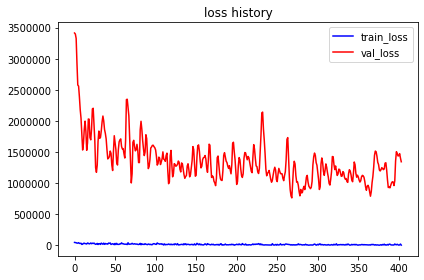

5/5 [==============================] - 0s 1ms/step
C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;03.56.11\korea_stateful_pdm_reg.best.hdf5
Epoch 0/3000
loss: [35291.47112685442], mae: [51.50611], mape: [538086340.0],val_loss: [3028005.1875], val_mae: [976.8209838867188], val_mape: [126.7806625366211]
976.8209838867188
Epoch 1/3000
loss: [48911.97380447388], mae: [98.502785], mape: [9375865000.0],val_loss: [3301787.825], val_mae: [1016.5384521484375], val_mape: [97.8880615234375]
1016.5384521484375
Epoch 2/3000
loss: [38135.29985482352], mae: [67.978874], mape: [2700949500.0],val_loss: [3186422.725], val_mae: [994.8895263671875], val_mape: [84.9851303100586]
994.8895263671875
Epoch 3/3000
loss: [46872.61707469395], mae: [87.8652], mape: [5201865700.0],val_loss: [3260392.1], val_mae: [1002.7802734375], val_mape: [65.7554931640625]
1002.7802734375
Epoch 4/3000
loss: [38750.06704166957], mae: [73.67245], mape: [4220396800.0],val_loss: [3167960.5625], val_mae: [992.

Epoch 45/3000
loss: [38342.343540736605], mae: [79.98247], mape: [2099301500.0],val_loss: [3202260.0], val_mae: [999.033203125], val_mape: [93.150390625]
999.033203125
Epoch 46/3000
loss: [36416.671910830904], mae: [71.82427], mape: [1760932000.0],val_loss: [3132059.675], val_mae: [985.8714599609375], val_mape: [87.64875793457031]
985.8714599609375
Epoch 47/3000
loss: [33605.16424560547], mae: [76.64829], mape: [1702709600.0],val_loss: [3103754.2], val_mae: [979.5072021484375], val_mape: [79.4118423461914]
979.5072021484375
Epoch 48/3000
loss: [38368.939125061035], mae: [84.3371], mape: [2643757000.0],val_loss: [3086497.0625], val_mae: [979.3643798828125], val_mape: [95.23812103271484]
979.3643798828125
Epoch 49/3000
loss: [43086.18909754072], mae: [86.4865], mape: [2245620200.0],val_loss: [3136460.7875], val_mae: [987.9649658203125], val_mape: [93.03944396972656]
987.9649658203125
Epoch 50/3000
loss: [37692.64994812012], mae: [76.301704], mape: [1368983400.0],val_loss: [3155984.4625],

Epoch 91/3000
loss: [38462.71247809274], mae: [71.474045], mape: [1306017000.0],val_loss: [3179749.9375], val_mae: [993.7542724609375], val_mape: [86.77262878417969]
993.7542724609375
Epoch 92/3000
loss: [41586.573372977124], mae: [79.76988], mape: [1450199400.0],val_loss: [3211311.9875], val_mae: [999.9567260742188], val_mape: [90.13634490966797]
999.9567260742188
Epoch 93/3000
loss: [39630.55351557051], mae: [73.18351], mape: [1649183700.0],val_loss: [3201358.8375], val_mae: [998.2410888671875], val_mape: [91.08424377441406]
998.2410888671875
Epoch 94/3000
loss: [37851.88583680562], mae: [66.81786], mape: [1592560500.0],val_loss: [3172859.4625], val_mae: [992.8038330078125], val_mape: [87.34759521484375]
992.8038330078125
Epoch 95/3000
loss: [40136.86729567392], mae: [82.539536], mape: [1581161700.0],val_loss: [3198149.2875], val_mae: [998.4266357421875], val_mape: [93.88140869140625]
998.4266357421875
Epoch 96/3000
loss: [39212.64438656398], mae: [75.93745], mape: [1283683200.0],val

Epoch 136/3000
loss: [41724.98751340593], mae: [72.669], mape: [1033254340.0],val_loss: [3233233.6625], val_mae: [1003.91943359375], val_mape: [91.82434844970703]
1003.91943359375
Epoch 137/3000
loss: [38436.793028150285], mae: [71.347115], mape: [1466036400.0],val_loss: [3226262.6875], val_mae: [1002.65576171875], val_mape: [91.9822998046875]
1002.65576171875
Epoch 138/3000
loss: [41499.36476789202], mae: [78.658134], mape: [1890788500.0],val_loss: [3201886.6375], val_mae: [997.8331909179688], val_mape: [88.04693603515625]
997.8331909179688
Epoch 139/3000
loss: [39219.202851840426], mae: [79.23497], mape: [1487207700.0],val_loss: [3241387.9875], val_mae: [1005.29443359375], val_mape: [91.54029846191406]
1005.29443359375
Epoch 140/3000
loss: [39707.61025755746], mae: [74.69641], mape: [1548839700.0],val_loss: [3205258.425], val_mae: [999.1708984375], val_mape: [91.89545440673828]
999.1708984375
Epoch 141/3000
loss: [44146.77109418596], mae: [83.68932], mape: [1448085800.0],val_loss: [3

Epoch 181/3000
loss: [36730.27546310425], mae: [78.168465], mape: [1562371300.0],val_loss: [3199089.45], val_mae: [997.1862182617188], val_mape: [86.74584197998047]
997.1862182617188
Epoch 182/3000
loss: [42270.690974644254], mae: [81.68203], mape: [1703286400.0],val_loss: [3179444.525], val_mae: [994.5977783203125], val_mape: [90.21223449707031]
994.5977783203125
Epoch 183/3000
loss: [36892.57821001326], mae: [76.25352], mape: [1377059200.0],val_loss: [3193405.05], val_mae: [996.8486328125], val_mape: [89.94541931152344]
996.8486328125
Epoch 184/3000
loss: [38422.24589102609], mae: [78.64413], mape: [1663668000.0],val_loss: [3205025.575], val_mae: [999.2730712890625], val_mape: [92.17975616455078]
999.2730712890625
Epoch 185/3000
loss: [38995.5855821882], mae: [77.092896], mape: [1314028500.0],val_loss: [3180316.2125], val_mae: [993.8197021484375], val_mape: [85.44342803955078]
993.8197021484375
Epoch 186/3000
loss: [36933.466609546114], mae: [72.229546], mape: [1300304100.0],val_loss

In [84]:
"""
Predict the korea spread of coronavirus with Dense modle
"""
k_pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=True, batch_size=8, n_feature=3, model_name='korea_pdm_reg', stateful=False)

hist = k_pdm_reg.fit(X_train=X_train,
                   y_train=y_train, 
                   validation_data=(X_test, y_test),
                   verbose=1,
                   epochs=3000)
show_train_hist(hist)
k_pdm_reg.load_best_weights()
loss_and_metrics = k_pdm_reg.evaluate(X_test=X_test, y_test=y_test)

oss_hist = LossHistory()
loss_hist.init()
k_pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=True, batch_size=1, n_feature=3, model_name='korea_stateful_pdm_reg', stateful=True, loss_hist=loss_hist)

min_mape = float(sys.maxsize)
patience = 200
n_mape_greater = 0
epochs = 3000
for i in range(epochs):
    hist = k_pdm_reg.fit(X_train=X_train, 
                       y_train=y_train, 
                       validation_data=(X_test, y_test),
                       epochs=1,
                       verbose=0)
    print(f'Epoch {i}/{epochs}')
    print(f"loss: {hist.history['loss']}, mae: {hist.history['mae']}, mape: {hist.history['mape']},"
          f"val_loss: {hist.history['val_loss']}, val_mae: {hist.history['val_mae']}, val_mape: {hist.history['val_mape']}")
    val_mape = hist.history['val_mae'][0]
    print(val_mape)
    if val_mape <= min_mape:
        min_mape = val_mape
        n_mape_greater = 0
        k_pdm_reg.save()
    else:
        n_mape_greater += 1
    if n_mape_greater > patience:
        break
k_pdm_reg.reset_states()

k_pdm_reg.load_best_weights()
loss_and_metrics = k_pdm_reg.evaluate(X_test=X_test, y_test=y_test)
k_pdm_reg.reset_states()

In [85]:
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = k_pdm_reg.predict(X_test)
pdm_reg.reset_states()
y_dict = {'Confirmed': [x[0] for x in y_hat],
          'Deaths':[x[1] for x in y_hat],
          'Recovered':[x[2] for x in y_hat]}
y_df = pd.DataFrame(y_dict)
y_df

MAE: 977.17578125, MAPE: 125.86470031738281
===================================================== Prediction of X_test =====================================================


,Confirmed,Deaths,Recovered
0,188.663910,-3.848068,64.599815
1,196.983124,-4.007370,67.450462
2,197.010696,-4.008329,67.458885
3,196.997513,-4.008687,67.453178
4,197.009995,-4.009485,67.456612


In [86]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = k_pdm_reg.predict_n_days(n, X_test[-1], {'mean': _mean, 'std': _std})
pdm_reg.reset_states()
prediction


===================================================== Prediction of 7 days =====================================================


,Confirmed,Deaths,Recovered
0,197.010,-4.009,67.457
1,197.458,-4.020,67.612
2,197.507,-4.021,67.629
3,197.511,-4.021,67.631
4,197.511,-4.021,67.631
5,197.511,-4.021,67.631
6,197.511,-4.021,67.631
